In [25]:
#hide
!nvidia-smi

Sat Jan 23 17:23:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    41W / 300W |   9799MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
#hide
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets axial_positional_embedding wandb
    !pip install -qq git+git://github.com/arampacha/reformer_fastai.git

     |████████████████████████████████| 194kB 13.0MB/s 
     |████████████████████████████████| 163kB 21.5MB/s 
     |████████████████████████████████| 1.9MB 22.6MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 17.7MB 76.2MB/s 
     |████████████████████████████████| 245kB 58.7MB/s 
     |████████████████████████████████| 133kB 60.2MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 163kB 57.6MB/s 
     |████████████████████████████████| 102kB 14.5MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [1]:
#hide
%load_ext autoreload
%autoreload 2

In [2]:
#all_slow

# enwik8 - shared QK

In [3]:
from fastai.text.all import *
from reformer_fastai.all import *

In [4]:
#Run setup
n_epochs = 4
bs = 1
sl = 2**14
n_layers = 3
seed = 2

## Experiment Tracking

Make sure you have wandb and are logged in:

In [5]:
# hide
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Load Experiment Tracking with Weights & Biases:

In [6]:
import wandb

WANDB_NAME = f'n_layers-{n_layers}_enwik8_sl-{sl}_bs-{bs}_n_eps-{n_epochs}_seed-{seed}'
GROUP = 'n_layers'
NOTES = 'ReformerLM on enwik8 sl=32k'
CONFIG = {}
TAGS = ['lm','lsh','enwik8', 'nlayers']

## Download and Unpack enwik8 Data

Download and unzip enwik8 data

In [7]:
path = untar_data('http://mattmahoney.net/dc/enwik8.zip', dest='/data')

## Prepare Data

In [8]:
df = pd.DataFrame({'text':read_lines(path)})
df.head()

,text
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml/export-0.3/"" xmlns:xsi=""http://www.w3.org/2001/XMLSchema-instance"" xsi:schemaLocation=""http://www.mediawiki.org/xml/export-0.3/ http://www.mediawiki.org/xml/export-0.3.xsd"" version=""0.3"" xml:lang=""en"">\n"
1,<siteinfo>\n
2,<sitename>Wikipedia</sitename>\n
3,<base>http://en.wikipedia.org/wiki/Main_Page</base>\n
4,<generator>MediaWiki 1.6alpha</generator>\n


In [9]:
btt = ByteTextTokenizer(is_lm=True, add_bos=False, add_eos=False)

In [10]:
#using ~1/4 of the data for this experiment
df = df[:len(df)//4].copy()

In [11]:
%%time
df['toks'] = df['text'].apply(btt)
df['lens'] = df['toks'].apply(len)
df['lens_cum_sum'] = df.lens.cumsum()

CPU times: user 31.4 s, sys: 933 ms, total: 32.3 s
Wall time: 30.8 s


In [12]:
train_cutoff = df.lens.sum() - 4_000_000  # keep all but 10M characters for val and test
train_idxs = df.loc[df['lens_cum_sum'] < train_cutoff].index.values
train_idxs = list(range(0, max(train_idxs)))

remaining_idxs = len(df) - max(train_idxs)
validation_idxs = list(range(max(train_idxs), max(train_idxs) + int(remaining_idxs/2)))
test_idxs = list(range(max(validation_idxs), len(df)))

splits = [train_idxs, validation_idxs]

In [13]:
tfms = [attrgetter("text"), btt]
dsets = Datasets(df, [tfms], splits=splits, dl_type=LMDataLoader)

In [14]:
%%time
dl_kwargs = [{'lens':df['lens'].values[train_idxs]},
             {'val_lens':df['lens'].values[validation_idxs]}]
dls = dsets.dataloaders(bs=bs, seq_len=sl, dl_kwargs=dl_kwargs, shuffle_train=True, n_workers=2)

CPU times: user 12.1 s, sys: 1.54 s, total: 13.7 s
Wall time: 16.3 s


In [15]:
#collapse_output
dls.show_batch()

,text,text_
0,"*[[1867]] - [[Philipp August Böckh]], German scholar and antiquarian (b. [[1785]])\n[[it:Accelerazione]]\n|[[Angel Marin]]\n*[[Flutina]]\n*[[1662]] - [[Charles Seymour, 6th Duke of Somerset]], English politician (d. [[1748]])\n* &quot;[[Belfast]]&quot;\nAs the second son of King Afonso II of Portugal, Afonso was not expected to inherit the throne, which was destined to go to his brother Sancho. He lived mostly in [[France]], were he married Matilda, the heiress of [[Boulogne]], in [[1238]], thereby becoming [[Count of Boulogne]]. In [[1246]], conflicts between his brother, the king, and the church became unbearable. [[Pope Innocent IV]] then ordered Sancho II to be removed from the throne and be replaced by the Count of Boulogne. Afonso, of course, did not refuse the papal order and marched to Portugal. Since Sancho was not a popular king, the order was not hard to enforce; he was exiled to [[Castile]] and Afonso III became king in [[1247]]. To ascend the throne, he abdicated from","[[1867]] - [[Philipp August Böckh]], German scholar and antiquarian (b. [[1785]])\n[[it:Accelerazione]]\n|[[Angel Marin]]\n*[[Flutina]]\n*[[1662]] - [[Charles Seymour, 6th Duke of Somerset]], English politician (d. [[1748]])\n* &quot;[[Belfast]]&quot;\nAs the second son of King Afonso II of Portugal, Afonso was not expected to inherit the throne, which was destined to go to his brother Sancho. He lived mostly in [[France]], were he married Matilda, the heiress of [[Boulogne]], in [[1238]], thereby becoming [[Count of Boulogne]]. In [[1246]], conflicts between his brother, the king, and the church became unbearable. [[Pope Innocent IV]] then ordered Sancho II to be removed from the throne and be replaced by the Count of Boulogne. Afonso, of course, did not refuse the papal order and marched to Portugal. Since Sancho was not a popular king, the order was not hard to enforce; he was exiled to [[Castile]] and Afonso III became king in [[1247]]. To ascend the throne, he abdicated from"


In [16]:
vocab_sz = btt.vocab_size

In [17]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

((1, 16384), (1, 16384))

In [18]:
#hide
del xb, yb
torch.cuda.empty_cache()

## Training

In [19]:
#hide_output
wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES, tags=TAGS, config=CONFIG)

wandb: Currently logged in as: fastai_community (use `wandb login --relogin` to force relogin)


In [20]:
pad_id = btt.pad_token_id
config = NLayersConfig(n_layers=n_layers, max_seq_len=sl, pad_idx=pad_id, seed=seed)
config

ReformerLM config 
--------------------
vocab_sz        256
d_model         1024
n_layers        3
n_heads         8
d_ff            4096
ff_chunks       64
attn_dropout    0.1
ff_dropout      0.1
emb_dropout     0.1
tie_weights     True
causal          True
pos_enc         axial
max_seq_len     16384
axial_shape     None
axial_emb_dims  None
pad_idx         0
prenorm         False
attn_bias       False
bucket_size     64
use_lsh         True
n_hashes        8
rev_thres       0
seed            2

In [21]:
learn = Learner(dls, ReformerLM.from_config(config),
                loss_func=CrossEntropyLossFlat(), opt_func=adafactor,
                cbs = [GradientAccumulation(n_acc=8), GradientClip(1.0),
                       PadBatchCallback(bucket_size=config.bucket_size,
                                        val=pad_id, y_val=pad_id)],
                metrics=[accuracy, perplexity, bpc])

In [22]:
#hide
# learn.lr_find()

In [23]:
learn.fit(n_epochs, cbs=WandbCallback(log_model=False, log_preds=False))

epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,2.864014,2.862855,0.201379,17.511459,4.130227,35:37


epoch,train_loss,valid_loss,accuracy,perplexity,bpc,time
0,2.864014,2.862855,0.201379,17.511459,4.130227,35:37
1,2.756311,2.754734,0.235094,15.716857,3.974241,35:46
2,2.724835,2.734553,0.231886,15.402855,3.945126,35:52
3,2.716689,2.714481,0.241486,15.096774,3.916168,36:02


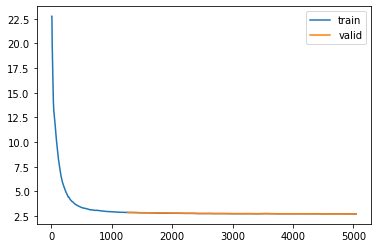

In [24]:
learn.recorder.plot_loss()